In [1]:
from lenskit.datasets import MovieLens
from lenskit.algorithms.basic import Bias
from lenskit.batch import predict
from lenskit.metrics.predict import rmse
import pandas as pd
import numpy as np
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

Precision Evalution

In [2]:
# ratings = MovieLens('C:/Users/bladesaber/Desktop/ml-latest-small').ratings

ratings = pd.read_csv('C:/Users/bladesaber/Desktop/ml-latest-small/ratings.csv')
ratings['rating'] = ratings['rating']*2.0
ratings.columns = ['user', 'item', 'rating', 'timestamp']

In [3]:
ratings.head()

,user,item,rating,timestamp
0,1,1,8.0,964982703
1,1,3,8.0,964981247
2,1,6,8.0,964982224
3,1,47,10.0,964983815
4,1,50,10.0,964982931


In [13]:
ratings.head()

,user,item,rating,timestamp
0,1,1,8.0,964982703
1,1,3,8.0,964981247
2,1,6,8.0,964982224
3,1,47,10.0,964983815
4,1,50,10.0,964982931


In [17]:
test = ratings.iloc[:1000]
train = ratings.iloc[1000:]
algo = Bias()
algo.fit(train)

In [18]:
preds = predict(algo, test)

In [19]:
user_rmse = preds.groupby('user').apply(lambda df: rmse(df.prediction, df.rating))
user_rmse.mean()

2.500443571638859

Ranking Evalution

In [19]:
# ml100k = ML100K('ml-100k')
# ratings = ml100k.ratings
ratings.head()

,user,item,rating,timestamp
0,1,1,8.0,964982703
1,1,3,8.0,964981247
2,1,6,8.0,964982224
3,1,47,10.0,964983815
4,1,50,10.0,964982931


In [20]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

In [37]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 8)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [38]:
all_recs = []
test_data = []

for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.25)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

In [39]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,6051,12.266129,11,1,ItemItem
1,2937,11.328878,11,2,ItemItem
2,25771,11.304793,11,3,ItemItem
3,117192,11.198938,11,4,ItemItem
4,26326,11.106425,11,5,ItemItem


In [40]:
test_data = pd.concat(test_data, ignore_index=True)

In [41]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs  ndcg
user Algorithm             
1    ALS          8.0   0.0
     ItemItem     8.0   0.0
2    ALS          8.0   0.0
     ItemItem     8.0   0.0
3    ALS          8.0   0.0

Algorithm
ALS         0.022805
ItemItem    0.000439
Name: ndcg, dtype: float64


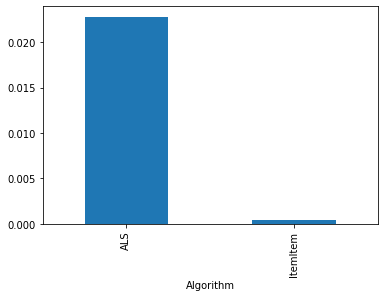

In [42]:
print(results.groupby('Algorithm').ndcg.mean())
results.groupby('Algorithm').ndcg.mean().plot.bar()

rating predict

In [4]:
ratings = util.load_ml_ratings('C:/Users/bladesaber/Desktop/ml-latest-small')

D:\ProgramData\Anaconda3\lib\site-packages\lenskit\util\data.py:90: UserWarning: load_ml_ratings is deprecated, use datsets.MovieLens.
  warnings.warn('load_ml_ratings is deprecated, use datsets.MovieLens.')


In [5]:
ratings['rating'] = ratings['rating']*2

In [6]:
ratings.nunique()

user           610
item          9724
rating          10
timestamp    85043
dtype: int64

In [7]:
ratings.head()

,user,item,rating,timestamp
0,1,1,8.0,964982703
1,1,3,8.0,964981247
2,1,6,8.0,964982224
3,1,47,10.0,964983815
4,1,50,10.0,964982931


In [55]:
# bias = Bias()
# bias.fit(ratings[:-1000])

# test = ratings.iloc[:1000]
# train = ratings.iloc[1000:]

# test = ratings[-1000:]
# train = ratings[:-1000]

# algo = Bias()
# algo.fit(train)

In [12]:
loss_list = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
#     algo = Bias()
    algo = als.BiasedMF(100)
    algo.fit(train)
    
    preds = predict(algo, test)
    loss = rmse(preds['prediction'], preds['rating'])
    loss_list.append(loss)

In [13]:
np.mean(loss_list)

1.6691486905377935

In [14]:
loss_list

[1.6789743707892253,
 1.635322772216936,
 1.6819955686733787,
 1.720338118505306,
 1.629112622504121]